# Price Finder Feature Extraction Model

This notebook contains the development of the CNN image classification model used in the Price Finder API to identify vehicles through images

## A quick run-through of the dataset


Example of file structure:

   * A `train` directory which contains all of the images in the training dataset with subdirectories each named after a certain class containing images of that class.
   * A `test` directory with the same structure as the train directory.
    
   * A `validate` directory with the same structure as above with images used to validate the model


```
images <- top level folder
└───train <- training images
│   └───Alto 2015
│   │   │   01005.jpg
│   │   │   08445.jpg
│   │   │   ...      
│   └───Toyota Aqua 2014
│       │   01654.jpg
│       │   05422.jpg
│       │   ...
│   
└───test <- testing images
│   └───Alto 2015
│   │   │   01545.jpg
│   │   │   01985.jpg
│   │   │   ...      
│   └───Toyota Aqua 2014
│       │   09655.jpg
│       │   01054.jpg
│       │   ...
│
└───validate <- validation images
│   └───Alto 2015
│   │   │   96505.jpg
│   │   │   01655.jpg
│   │   │   ...      
│   └───Toyota Aqua 2014
│       │   09866.jpg
│       │   35444.jpg
│       │   ...
```

In [5]:
from helper_script import walk_through_dir

# The path to the images folder that contains the train/test/validate image sets
PATH = "images"

walk_through_dir(PATH)

There are 3 directories and 0 images in 'images'.
There are 4 directories and 0 images in 'images\test'.
There are 0 directories and 139 images in 'images\test\Alto 2015'.
There are 0 directories and 51 images in 'images\test\Hero Dash 2016'.
There are 0 directories and 113 images in 'images\test\Toyota Aqua 2014'.
There are 0 directories and 98 images in 'images\test\Wagon R Stingray 2018'.
There are 4 directories and 0 images in 'images\train'.
There are 0 directories and 1252 images in 'images\train\Alto 2015'.
There are 0 directories and 405 images in 'images\train\Hero Dash 2016'.
There are 0 directories and 897 images in 'images\train\Toyota Aqua 2014'.
There are 0 directories and 782 images in 'images\train\Wagon R Stingray 2018'.
There are 4 directories and 0 images in 'images\validate'.
There are 0 directories and 140 images in 'images\validate\Alto 2015'.
There are 0 directories and 51 images in 'images\validate\Hero Dash 2016'.
There are 0 directories and 112 images in 'imag

In [3]:
# Get the class names 

import pathlib
import numpy as np

data_dir = pathlib.Path("images/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # create a list of class_names from the subdirectories
print(class_names) 

['Alto 2015' 'Hero Dash 2016' 'Toyota Aqua 2014' 'Wagon R Stingray 2018']


['245135.jpg']
Image shape:  (465, 620, 3)


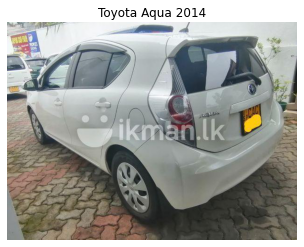

In [4]:
# View a random image from train dataset

from helper_script import view_random_image

img = view_random_image(target_dir="images/train/", target_class="Toyota Aqua 2014")

In [6]:
# Check additional details about the images, such as image shape and data type

from helper_script import check_images

check_images(PATH)

File Name: 01005.jpg Shape: (454, 340, 3) Image datatype: <dtype: 'uint8'>
File Name: 01009.jpg Shape: (500, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01023.jpg Shape: (810, 1079, 3) Image datatype: <dtype: 'uint8'>
File Name: 01028.jpg Shape: (551, 734, 3) Image datatype: <dtype: 'uint8'>
File Name: 01040.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 01041.jpg Shape: (459, 669, 3) Image datatype: <dtype: 'uint8'>
File Name: 01045.jpg Shape: (479, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 01049.jpg Shape: (800, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 01054.jpg Shape: (500, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01062.jpg Shape: (570, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 01064.jpg Shape: (338, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 01069.jpg Shape: (567, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01070.jpg Shape: (464, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01078.jpg Sha

File Name: 0398.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0406.jpg Shape: (800, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 0413.jpg Shape: (1350, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 0425.jpg Shape: (352, 678, 3) Image datatype: <dtype: 'uint8'>
File Name: 0440.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 0441.jpg Shape: (800, 449, 3) Image datatype: <dtype: 'uint8'>
File Name: 0442.jpg Shape: (768, 768, 3) Image datatype: <dtype: 'uint8'>
File Name: 0449.jpg Shape: (800, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0459.jpg Shape: (351, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 0461.jpg Shape: (421, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0464.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0475.jpg Shape: (800, 379, 3) Image datatype: <dtype: 'uint8'>
File Name: 0477.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 0480.jpg Shape: (683, 1024

File Name: 00541.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00551.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00558.jpg Shape: (568, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 00561.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00565.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00567.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00571.jpg Shape: (500, 667, 3) Image datatype: <dtype: 'uint8'>
File Name: 00572.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00586.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 00590.jpg Shape: (450, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 00601.jpg Shape: (465, 637, 3) Image datatype: <dtype: 'uint8'>
File Name: 00618.jpg Shape: (570, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 00620.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00631.jpg Shap

File Name: 01090.jpg Shape: (400, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 01092.jpg Shape: (720, 960, 3) Image datatype: <dtype: 'uint8'>
File Name: 01094.jpg Shape: (720, 960, 3) Image datatype: <dtype: 'uint8'>
File Name: 01097.jpg Shape: (800, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01098.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01099.jpg Shape: (459, 669, 3) Image datatype: <dtype: 'uint8'>
File Name: 0110.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01100.jpg Shape: (551, 734, 3) Image datatype: <dtype: 'uint8'>
File Name: 01101.jpg Shape: (500, 500, 3) Image datatype: <dtype: 'uint8'>
File Name: 01103.jpg Shape: (851, 1600, 3) Image datatype: <dtype: 'uint8'>
File Name: 01104.jpg Shape: (338, 540, 3) Image datatype: <dtype: 'uint8'>
File Name: 01105.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 01106.jpg Shape: (368, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01107.jpg Shap

File Name: 01266.jpg Shape: (1080, 1439, 3) Image datatype: <dtype: 'uint8'>
File Name: 01267.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 01269.jpg Shape: (500, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0127.jpg Shape: (810, 1079, 3) Image datatype: <dtype: 'uint8'>
File Name: 01270.jpg Shape: (459, 669, 3) Image datatype: <dtype: 'uint8'>
File Name: 01272.jpg Shape: (375, 500, 3) Image datatype: <dtype: 'uint8'>
File Name: 01274.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 01275.jpg Shape: (547, 717, 3) Image datatype: <dtype: 'uint8'>
File Name: 01276.jpg Shape: (375, 500, 3) Image datatype: <dtype: 'uint8'>
File Name: 01277.jpg Shape: (375, 500, 3) Image datatype: <dtype: 'uint8'>
File Name: 01278.jpg Shape: (459, 669, 3) Image datatype: <dtype: 'uint8'>
File Name: 01279.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 0128.jpg Shape: (478, 850, 3) Image datatype: <dtype: 'uint8'>
File Name: 01280.jpg Sha

File Name: 0173.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 0174.jpg Shape: (720, 1280, 3) Image datatype: <dtype: 'uint8'>
File Name: 0175.jpg Shape: (709, 719, 3) Image datatype: <dtype: 'uint8'>
File Name: 0176.jpg Shape: (415, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0177.jpg Shape: (1014, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 0178.jpg Shape: (800, 923, 3) Image datatype: <dtype: 'uint8'>
File Name: 0179.jpg Shape: (620, 826, 3) Image datatype: <dtype: 'uint8'>
File Name: 018.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0180.jpg Shape: (375, 500, 3) Image datatype: <dtype: 'uint8'>
File Name: 0181.jpg Shape: (420, 630, 3) Image datatype: <dtype: 'uint8'>
File Name: 0182.jpg Shape: (584, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0183.jpg Shape: (753, 1079, 3) Image datatype: <dtype: 'uint8'>
File Name: 0186.jpg Shape: (720, 721, 3) Image datatype: <dtype: 'uint8'>
File Name: 0187.jpg Shape: (638, 102

File Name: 0347.jpg Shape: (800, 450, 3) Image datatype: <dtype: 'uint8'>
File Name: 0349.jpg Shape: (810, 1079, 3) Image datatype: <dtype: 'uint8'>
File Name: 0350.jpg Shape: (453, 340, 3) Image datatype: <dtype: 'uint8'>
File Name: 0351.jpg Shape: (380, 500, 3) Image datatype: <dtype: 'uint8'>
File Name: 0352.jpg Shape: (420, 750, 3) Image datatype: <dtype: 'uint8'>
File Name: 0353.jpg Shape: (810, 1079, 3) Image datatype: <dtype: 'uint8'>
File Name: 0354.jpg Shape: (362, 482, 3) Image datatype: <dtype: 'uint8'>
File Name: 0355.jpg Shape: (720, 1280, 3) Image datatype: <dtype: 'uint8'>
File Name: 0356.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 0359.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 036.jpg Shape: (459, 669, 3) Image datatype: <dtype: 'uint8'>
File Name: 0360.jpg Shape: (688, 1024, 3) Image datatype: <dtype: 'uint8'>
File Name: 0361.jpg Shape: (384, 486, 3) Image datatype: <dtype: 'uint8'>
File Name: 0362.jpg Shape: (403, 64

File Name: 0535.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0536.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0537.jpg Shape: (300, 400, 3) Image datatype: <dtype: 'uint8'>
File Name: 0538.jpg Shape: (550, 827, 3) Image datatype: <dtype: 'uint8'>
File Name: 0539.jpg Shape: (500, 667, 3) Image datatype: <dtype: 'uint8'>
File Name: 054.jpg Shape: (459, 669, 3) Image datatype: <dtype: 'uint8'>
File Name: 0540.jpg Shape: (800, 1067, 3) Image datatype: <dtype: 'uint8'>
File Name: 0542.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0543.jpg Shape: (570, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 0544.jpg Shape: (420, 750, 3) Image datatype: <dtype: 'uint8'>
File Name: 0545.jpg Shape: (300, 400, 3) Image datatype: <dtype: 'uint8'>
File Name: 0547.jpg Shape: (480, 853, 3) Image datatype: <dtype: 'uint8'>
File Name: 0548.jpg Shape: (550, 733, 3) Image datatype: <dtype: 'uint8'>
File Name: 0549.jpg Shape: (600, 800, 

File Name: 0716.jpg Shape: (550, 733, 3) Image datatype: <dtype: 'uint8'>
File Name: 0717.jpg Shape: (450, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 0718.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0719.jpg Shape: (550, 733, 3) Image datatype: <dtype: 'uint8'>
File Name: 072.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0720.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0722.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0723.jpg Shape: (800, 1067, 3) Image datatype: <dtype: 'uint8'>
File Name: 0724.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0726.jpg Shape: (800, 1067, 3) Image datatype: <dtype: 'uint8'>
File Name: 0727.jpg Shape: (685, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0728.jpg Shape: (358, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 073.jpg Shape: (1227, 1500, 3) Image datatype: <dtype: 'uint8'>
File Name: 0730.jpg Shape: (800, 106

File Name: 0897.jpg Shape: (1333, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 090.jpg Shape: (451, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0901.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0902.jpg Shape: (570, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 0907.jpg Shape: (799, 1077, 3) Image datatype: <dtype: 'uint8'>
File Name: 0908.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0909.jpg Shape: (500, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 091.jpg Shape: (638, 850, 3) Image datatype: <dtype: 'uint8'>
File Name: 0910.jpg Shape: (683, 1000, 3) Image datatype: <dtype: 'uint8'>
File Name: 0911.jpg Shape: (782, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0912.jpg Shape: (485, 647, 3) Image datatype: <dtype: 'uint8'>
File Name: 0913.jpg Shape: (856, 1079, 3) Image datatype: <dtype: 'uint8'>
File Name: 0914.jpg Shape: (450, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0916.jpg Shape: (600, 800

File Name: 684685.jpg Shape: (466, 410, 3) Image datatype: <dtype: 'uint8'>
File Name: 68484.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 68498.jpg Shape: (291, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 68515631.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 6854165441.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 68544.jpg Shape: (464, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 685456354.jpg Shape: (466, 529, 3) Image datatype: <dtype: 'uint8'>
File Name: 68545865.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 685465.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 6854654.jpg Shape: (466, 365, 3) Image datatype: <dtype: 'uint8'>
File Name: 685468.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 68553.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 685544.jpg Shape: (466, 538, 3) Image datatype: <dtype: 'uint8'>
File

File Name: 0312.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 0313.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0314.jpg Shape: (603, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0315.jpg Shape: (800, 521, 3) Image datatype: <dtype: 'uint8'>
File Name: 0317.jpg Shape: (960, 720, 3) Image datatype: <dtype: 'uint8'>
File Name: 0320.jpg Shape: (1200, 900, 3) Image datatype: <dtype: 'uint8'>
File Name: 0322.jpg Shape: (853, 1280, 3) Image datatype: <dtype: 'uint8'>
File Name: 0328.jpg Shape: (644, 483, 3) Image datatype: <dtype: 'uint8'>
File Name: 0332.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0334.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0335.jpg Shape: (720, 1280, 3) Image datatype: <dtype: 'uint8'>
File Name: 0337.jpg Shape: (800, 357, 3) Image datatype: <dtype: 'uint8'>
File Name: 0338.jpg Shape: (800, 599, 3) Image datatype: <dtype: 'uint8'>
File Name: 0339.jpg Shape: (1600, 9

File Name: 0563.jpg Shape: (2000, 900, 3) Image datatype: <dtype: 'uint8'>
File Name: 0565.jpg Shape: (800, 1067, 3) Image datatype: <dtype: 'uint8'>
File Name: 0568.jpg Shape: (603, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0569.jpg Shape: (800, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 057.jpg Shape: (1280, 973, 3) Image datatype: <dtype: 'uint8'>
File Name: 0571.jpg Shape: (800, 1067, 3) Image datatype: <dtype: 'uint8'>
File Name: 0574.jpg Shape: (1013, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 0575.jpg Shape: (800, 360, 3) Image datatype: <dtype: 'uint8'>
File Name: 0576.jpg Shape: (800, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 0577.jpg Shape: (603, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 058.jpg Shape: (338, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 0580.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0581.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0582.jpg Shape: (1040, 7

File Name: 01010.jpg Shape: (2136, 3316, 3) Image datatype: <dtype: 'uint8'>
File Name: 01011.jpg Shape: (800, 1067, 3) Image datatype: <dtype: 'uint8'>
File Name: 01016.jpg Shape: (300, 400, 3) Image datatype: <dtype: 'uint8'>
File Name: 01017.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0102.jpg Shape: (451, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01024.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 01025.jpg Shape: (900, 1200, 3) Image datatype: <dtype: 'uint8'>
File Name: 01027.jpg Shape: (375, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01028.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 01030.jpg Shape: (449, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 01031.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01033.jpg Shape: (720, 1280, 3) Image datatype: <dtype: 'uint8'>
File Name: 01035.jpg Shape: (449, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01037.jpg 

File Name: 01250.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 01251.jpg Shape: (1800, 2400, 3) Image datatype: <dtype: 'uint8'>
File Name: 01253.jpg Shape: (600, 799, 3) Image datatype: <dtype: 'uint8'>
File Name: 01254.jpg Shape: (449, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01255.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01258.jpg Shape: (570, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 01259.jpg Shape: (640, 960, 3) Image datatype: <dtype: 'uint8'>
File Name: 0126.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 01260.jpg Shape: (300, 400, 3) Image datatype: <dtype: 'uint8'>
File Name: 01261.jpg Shape: (853, 1280, 3) Image datatype: <dtype: 'uint8'>
File Name: 01262.jpg Shape: (625, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 01264.jpg Shape: (632, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 01267.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 01268.jpg Sh

File Name: 0213.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0214.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0216.jpg Shape: (750, 1000, 3) Image datatype: <dtype: 'uint8'>
File Name: 0217.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0219.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 022.jpg Shape: (526, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 0220.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0221.jpg Shape: (720, 960, 3) Image datatype: <dtype: 'uint8'>
File Name: 0222.jpg Shape: (1536, 2048, 3) Image datatype: <dtype: 'uint8'>
File Name: 0226.jpg Shape: (1200, 1600, 3) Image datatype: <dtype: 'uint8'>
File Name: 023.jpg Shape: (387, 578, 3) Image datatype: <dtype: 'uint8'>
File Name: 0230.jpg Shape: (200, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0234.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0236.jpg Shape: (1536, 2

File Name: 0432.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0433.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0434.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0435.jpg Shape: (620, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0437.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0438.jpg Shape: (720, 1280, 3) Image datatype: <dtype: 'uint8'>
File Name: 0439.jpg Shape: (598, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0440.jpg Shape: (338, 450, 3) Image datatype: <dtype: 'uint8'>
File Name: 0444.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0446.jpg Shape: (517, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0447.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 045.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0450.jpg Shape: (1200, 1600, 3) Image datatype: <dtype: 'uint8'>
File Name: 0451.jpg Shape: (773, 120

File Name: 0696.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0697.jpg Shape: (304, 650, 3) Image datatype: <dtype: 'uint8'>
File Name: 0701.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0709.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0710.jpg Shape: (427, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0711.jpg Shape: (500, 667, 3) Image datatype: <dtype: 'uint8'>
File Name: 0712.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0713.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0714.jpg Shape: (1080, 1920, 3) Image datatype: <dtype: 'uint8'>
File Name: 0717.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0718.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 072.jpg Shape: (516, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0720.jpg Shape: (683, 1024, 3) Image datatype: <dtype: 'uint8'>
File Name: 0721.jpg Shape: (600, 800

File Name: 0950.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0951.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0952.jpg Shape: (450, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0953.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0956.jpg Shape: (582, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0958.jpg Shape: (1200, 1600, 3) Image datatype: <dtype: 'uint8'>
File Name: 0961.jpg Shape: (532, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0962.jpg Shape: (450, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 0963.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0964.jpg Shape: (400, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0966.jpg Shape: (960, 1280, 3) Image datatype: <dtype: 'uint8'>
File Name: 0968.jpg Shape: (800, 621, 3) Image datatype: <dtype: 'uint8'>
File Name: 097.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0970.jpg Shape: (338, 450

File Name: 00125.jpg Shape: (442, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00126.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00127.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00128.jpg Shape: (450, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 00129.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0013.jpg Shape: (361, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00130.jpg Shape: (1000, 1000, 3) Image datatype: <dtype: 'uint8'>
File Name: 00132.jpg Shape: (640, 960, 3) Image datatype: <dtype: 'uint8'>
File Name: 00133.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00134.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00135.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00136.jpg Shape: (466, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00137.jpg Shape: (597, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00138.jpg Sha

File Name: 0028.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00280.jpg Shape: (550, 707, 3) Image datatype: <dtype: 'uint8'>
File Name: 00281.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00282.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00283.jpg Shape: (480, 853, 3) Image datatype: <dtype: 'uint8'>
File Name: 00285.jpg Shape: (300, 400, 3) Image datatype: <dtype: 'uint8'>
File Name: 00286.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00288.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00289.jpg Shape: (360, 480, 3) Image datatype: <dtype: 'uint8'>
File Name: 0029.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00290.jpg Shape: (477, 637, 3) Image datatype: <dtype: 'uint8'>
File Name: 00292.jpg Shape: (578, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 00293.jpg Shape: (450, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 00294.jpg Shape:

File Name: 00444.jpg Shape: (3024, 4032, 3) Image datatype: <dtype: 'uint8'>
File Name: 00445.jpg Shape: (1013, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 00446.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00447.jpg Shape: (603, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00448.jpg Shape: (450, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 00449.jpg Shape: (570, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 00450.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00451.jpg Shape: (500, 667, 3) Image datatype: <dtype: 'uint8'>
File Name: 00452.jpg Shape: (570, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 00453.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00456.jpg Shape: (1012, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 00457.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00459.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0046.jpg S

File Name: 00679.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0068.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00681.jpg Shape: (570, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 00682.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00683.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00684.jpg Shape: (300, 400, 3) Image datatype: <dtype: 'uint8'>
File Name: 00685.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00687.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00689.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 00690.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00691.jpg Shape: (478, 637, 3) Image datatype: <dtype: 'uint8'>
File Name: 00692.jpg Shape: (550, 734, 3) Image datatype: <dtype: 'uint8'>
File Name: 00694.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 00696.jpg Shape

File Name: 6510.jpg Shape: (353, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 6511.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 65110.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 65125.jpg Shape: (466, 350, 3) Image datatype: <dtype: 'uint8'>
File Name: 651321.jpg Shape: (466, 350, 3) Image datatype: <dtype: 'uint8'>
File Name: 651510.jpg Shape: (466, 350, 3) Image datatype: <dtype: 'uint8'>
File Name: 651511.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 6515110.jpg Shape: (466, 350, 3) Image datatype: <dtype: 'uint8'>
File Name: 6515145.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 651515.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 651531.jpg Shape: (465, 620, 3) Image datatype: <dtype: 'uint8'>
File Name: 652.jpg Shape: (466, 350, 3) Image datatype: <dtype: 'uint8'>
File Name: 65230.jpg Shape: (466, 350, 3) Image datatype: <dtype: 'uint8'>
File Name: 6540.jpg 

File Name: 0657.jpg Shape: (300, 300, 3) Image datatype: <dtype: 'uint8'>
File Name: 0659.jpg Shape: (800, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 0668.jpg Shape: (500, 657, 3) Image datatype: <dtype: 'uint8'>
File Name: 0672.jpg Shape: (570, 760, 3) Image datatype: <dtype: 'uint8'>
File Name: 0674.jpg Shape: (550, 504, 3) Image datatype: <dtype: 'uint8'>
File Name: 0677.jpg Shape: (533, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 068.jpg Shape: (485, 1077, 3) Image datatype: <dtype: 'uint8'>
File Name: 0685.jpg Shape: (599, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0688.jpg Shape: (480, 688, 3) Image datatype: <dtype: 'uint8'>
File Name: 0689.jpg Shape: (508, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 07.jpg Shape: (608, 1079, 3) Image datatype: <dtype: 'uint8'>
File Name: 071.jpg Shape: (733, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 074.jpg Shape: (418, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 080.jpg Shape: (810, 1079, 3) 

File Name: 044.jpg Shape: (720, 1280, 3) Image datatype: <dtype: 'uint8'>
File Name: 0441.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0445.jpg Shape: (633, 845, 3) Image datatype: <dtype: 'uint8'>
File Name: 0466.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0477.jpg Shape: (530, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0482.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0487.jpg Shape: (600, 600, 3) Image datatype: <dtype: 'uint8'>
File Name: 0490.jpg Shape: (599, 900, 3) Image datatype: <dtype: 'uint8'>
File Name: 0493.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0500.jpg Shape: (600, 800, 3) Image datatype: <dtype: 'uint8'>
File Name: 0502.jpg Shape: (667, 500, 3) Image datatype: <dtype: 'uint8'>
File Name: 0520.jpg Shape: (938, 1500, 3) Image datatype: <dtype: 'uint8'>
File Name: 0524.jpg Shape: (480, 640, 3) Image datatype: <dtype: 'uint8'>
File Name: 0532.jpg Shape: (450, 600,

## Image preprocessing

Image preprocessing is done through converting the downloaded images into rgb color format since there can be instances where images of different types such as png to be automatically saved as jpg through the web scraper used, but in reality they would still contain that extra alpha channel making those images 4-channels. For the model that is developed for the Price Finder API, all the images should be converted in 3-channels. Therefore RGB

In [2]:
# A script from the helper_script is used to convert the images

from helper_script import convert_images_rgb

convert_images_rgb(PATH)

File Name: 01005.jpg Type: jpeg
File Name: 01009.jpg Type: jpeg
File Name: 01023.jpg Type: jpeg
File Name: 01028.jpg Type: jpeg
File Name: 01040.jpg Type: jpeg
File Name: 01041.jpg Type: jpeg
File Name: 01045.jpg Type: jpeg
File Name: 01049.jpg Type: jpeg
File Name: 01054.jpg Type: jpeg
File Name: 01062.jpg Type: jpeg
File Name: 01064.jpg Type: jpeg
File Name: 01069.jpg Type: jpeg
File Name: 01070.jpg Type: jpeg
File Name: 01078.jpg Type: jpeg
File Name: 01079.jpg Type: jpeg
File Name: 01093.jpg Type: jpeg
File Name: 01095.jpg Type: jpeg
File Name: 01102.jpg Type: jpeg
File Name: 01108.jpg Type: jpeg
File Name: 01110.jpg Type: jpeg
File Name: 01111.jpg Type: jpeg
File Name: 01118.jpg Type: jpeg
File Name: 01130.jpg Type: jpeg
File Name: 01135.jpg Type: jpeg
File Name: 01136.jpg Type: jpeg
File Name: 01138.jpg Type: jpeg
File Name: 01152.jpg Type: jpeg
File Name: 01159.jpg Type: jpeg
File Name: 01178.jpg Type: jpeg
File Name: 01189.jpg Type: jpeg
File Name: 01190.jpg Type: jpeg
File Nam

File Name: 235202.jpg Type: jpeg
File Name: 2411211.jpg Type: jpeg
File Name: 2415241.jpg Type: jpeg
File Name: 2513.jpg Type: jpeg
File Name: 320203.jpg Type: jpeg
File Name: 3203250.jpg Type: jpeg
File Name: 32101.jpg Type: jpeg
File Name: 3512.jpg Type: jpeg
File Name: 351311.jpg Type: jpeg
File Name: 3513521.jpg Type: jpeg
File Name: 353351.jpg Type: jpeg
File Name: 35435.jpg Type: jpeg
File Name: 35435351.jpg Type: jpeg
File Name: 3543541.jpg Type: jpeg
File Name: 412431.jpg Type: jpeg
File Name: 4511.jpg Type: jpeg
File Name: 4554.jpg Type: jpeg
File Name: 51454.jpg Type: jpeg
File Name: 52415.jpg Type: jpeg
File Name: 5451.jpg Type: jpeg
File Name: 55454.jpg Type: jpeg
File Name: 5641.jpg Type: jpeg
File Name: 574654.jpg Type: jpeg
File Name: 635441.jpg Type: jpeg
File Name: 63545.jpg Type: jpeg
File Name: 6514.jpg Type: jpeg
File Name: 654534.jpg Type: jpeg
File Name: 658463.jpg Type: jpeg
File Name: 6854165.jpg Type: jpeg
File Name: 999.jpg Type: jpeg
File Name: 00509.jpg Type

File Name: 01149.jpg Type: jpeg
File Name: 01150.jpg Type: jpeg
File Name: 01151.jpg Type: jpeg
File Name: 01153.jpg Type: jpeg
File Name: 01154.jpg Type: jpeg
File Name: 01157.jpg Type: jpeg
File Name: 01158.jpg Type: jpeg
File Name: 0116.jpg Type: jpeg
File Name: 01160.jpg Type: jpeg
File Name: 01161.jpg Type: jpeg
File Name: 01162.jpg Type: jpeg
File Name: 01163.jpg Type: jpeg
File Name: 01164.jpg Type: jpeg
File Name: 01165.jpg Type: jpeg
File Name: 01166.jpg Type: jpeg
File Name: 01167.jpg Type: jpeg
File Name: 01168.jpg Type: jpeg
File Name: 01169.jpg Type: jpeg
File Name: 01170.jpg Type: jpeg
File Name: 01171.jpg Type: jpeg
File Name: 01172.jpg Type: jpeg
File Name: 01173.jpg Type: jpeg
File Name: 01174.jpg Type: jpeg
File Name: 01175.jpg Type: jpeg
File Name: 01176.jpg Type: jpeg
File Name: 01177.jpg Type: jpeg
File Name: 01179.jpg Type: jpeg
File Name: 0118.jpg Type: jpeg
File Name: 01180.jpg Type: jpeg
File Name: 01181.jpg Type: jpeg
File Name: 01182.jpg Type: jpeg
File Name:

File Name: 0179.jpg Type: jpeg
File Name: 018.jpg Type: jpeg
File Name: 0180.jpg Type: jpeg
File Name: 0181.jpg Type: jpeg
File Name: 0182.jpg Type: jpeg
File Name: 0183.jpg Type: jpeg
File Name: 0186.jpg Type: jpeg
File Name: 0187.jpg Type: jpeg
File Name: 0188.jpg Type: jpeg
File Name: 0189.jpg Type: jpeg
File Name: 019.jpg Type: jpeg
File Name: 0191.jpg Type: jpeg
File Name: 0192.jpg Type: jpeg
File Name: 0193.jpg Type: jpeg
File Name: 0195.jpg Type: jpeg
File Name: 0196.jpg Type: jpeg
File Name: 0198.jpg Type: jpeg
File Name: 0199.jpg Type: jpeg
File Name: 020.jpg Type: jpeg
File Name: 0200.jpg Type: jpeg
File Name: 0201.jpg Type: jpeg
File Name: 0202.jpg Type: jpeg
File Name: 0203.jpg Type: jpeg
File Name: 0204.jpg Type: jpeg
File Name: 0205.jpg Type: jpeg
File Name: 0206.jpg Type: jpeg
File Name: 0208.jpg Type: jpeg
File Name: 0209.jpg Type: jpeg
File Name: 0210.jpg Type: jpeg
File Name: 0211.jpg Type: jpeg
File Name: 0212.jpg Type: jpeg
File Name: 0213.jpg Type: jpeg
File Name: 

File Name: 0494.jpg Type: jpeg
File Name: 0496.jpg Type: jpeg
File Name: 0497.jpg Type: jpeg
File Name: 0498.jpg Type: jpeg
File Name: 0499.jpg Type: jpeg
File Name: 05.jpg Type: jpeg
File Name: 050.jpg Type: jpeg
File Name: 0500.jpg Type: jpeg
File Name: 0501.jpg Type: jpeg
File Name: 0502.jpg Type: jpeg
File Name: 0503.jpg Type: jpeg
File Name: 0504.jpg Type: jpeg
File Name: 0505.jpg Type: jpeg
File Name: 0509.jpg Type: jpeg
File Name: 051.jpg Type: jpeg
File Name: 0510.jpg Type: jpeg
File Name: 0511.jpg Type: jpeg
File Name: 0512.jpg Type: jpeg
File Name: 0514.jpg Type: jpeg
File Name: 0515.jpg Type: jpeg
File Name: 0518.jpg Type: jpeg
File Name: 0519.jpg Type: jpeg
File Name: 052.jpg Type: jpeg
File Name: 0520.jpg Type: jpeg
File Name: 0521.jpg Type: jpeg
File Name: 0522.jpg Type: jpeg
File Name: 0523.jpg Type: jpeg
File Name: 0524.jpg Type: jpeg
File Name: 0526.jpg Type: jpeg
File Name: 0527.jpg Type: jpeg
File Name: 0528.jpg Type: jpeg
File Name: 0529.jpg Type: jpeg
File Name: 05

File Name: 0810.jpg Type: jpeg
File Name: 0813.jpg Type: jpeg
File Name: 0815.jpg Type: jpeg
File Name: 0816.jpg Type: jpeg
File Name: 0817.jpg Type: jpeg
File Name: 0818.jpg Type: jpeg
File Name: 0820.jpg Type: jpeg
File Name: 0821.jpg Type: jpeg
File Name: 0822.jpg Type: jpeg
File Name: 0823.jpg Type: jpeg
File Name: 0824.jpg Type: jpeg
File Name: 0825.jpg Type: jpeg
File Name: 0827.jpg Type: jpeg
File Name: 0828.jpg Type: jpeg
File Name: 0829.jpg Type: jpeg
File Name: 083.jpg Type: jpeg
File Name: 0830.jpg Type: jpeg
File Name: 0831.jpg Type: jpeg
File Name: 0832.jpg Type: jpeg
File Name: 0833.jpg Type: jpeg
File Name: 0835.jpg Type: jpeg
File Name: 0836.jpg Type: jpeg
File Name: 0837.jpg Type: jpeg
File Name: 084.jpg Type: jpeg
File Name: 0840.jpg Type: jpeg
File Name: 0844.jpg Type: jpeg
File Name: 0845.jpg Type: jpeg
File Name: 0847.jpg Type: jpeg
File Name: 0848.jpg Type: jpeg
File Name: 0849.jpg Type: jpeg
File Name: 085.jpg Type: jpeg
File Name: 0850.jpg Type: jpeg
File Name: 

File Name: 684543.jpg Type: jpeg
File Name: 68456584.jpg Type: jpeg
File Name: 684568.jpg Type: jpeg
File Name: 68464.jpg Type: jpeg
File Name: 684641.jpg Type: jpeg
File Name: 684654.jpg Type: jpeg
File Name: 684684.jpg Type: jpeg
File Name: 684685.jpg Type: jpeg
File Name: 68484.jpg Type: jpeg
File Name: 68498.jpg Type: jpeg
File Name: 68515631.jpg Type: jpeg
File Name: 6854165441.jpg Type: jpeg
File Name: 68544.jpg Type: jpeg
File Name: 685456354.jpg Type: jpeg
File Name: 68545865.jpg Type: jpeg
File Name: 685465.jpg Type: jpeg
File Name: 6854654.jpg Type: jpeg
File Name: 685468.jpg Type: jpeg
File Name: 68553.jpg Type: jpeg
File Name: 685544.jpg Type: jpeg
File Name: 6856.jpg Type: jpeg
File Name: 68564.jpg Type: jpeg
File Name: 685685.jpg Type: jpeg
File Name: 6874684.jpg Type: jpeg
File Name: 68956.jpg Type: jpeg
File Name: 7574.jpg Type: jpeg
File Name: 7758774.jpg Type: jpeg
File Name: 784744.jpg Type: jpeg
File Name: 845654.jpg Type: jpeg
File Name: 8484864.jpg Type: jpeg
File

File Name: 0473.jpg Type: jpeg
File Name: 0474.jpg Type: jpeg
File Name: 0476.jpg Type: jpeg
File Name: 048.jpg Type: jpeg
File Name: 0485.jpg Type: jpeg
File Name: 0488.jpg Type: jpeg
File Name: 0490.jpg Type: jpeg
File Name: 0491.jpg Type: jpeg
File Name: 0493.jpg Type: jpeg
File Name: 0495.jpg Type: jpeg
File Name: 0497.jpg Type: jpeg
File Name: 0498.jpg Type: jpeg
File Name: 0502.jpg Type: jpeg
File Name: 0503.jpg Type: jpeg
File Name: 0505.jpg Type: jpeg
File Name: 0506.jpg Type: jpeg
File Name: 0509.jpg Type: jpeg
File Name: 0511.jpg Type: jpeg
File Name: 0516.jpg Type: jpeg
File Name: 0518.jpg Type: jpeg
File Name: 0519.jpg Type: jpeg
File Name: 052.jpg Type: jpeg
File Name: 0521.jpg Type: jpeg
File Name: 0522.jpg Type: jpeg
File Name: 0523.jpg Type: jpeg
File Name: 0524.jpg Type: jpeg
File Name: 0525.jpg Type: jpeg
File Name: 0527.jpg Type: jpeg
File Name: 0529.jpg Type: jpeg
File Name: 053.jpg Type: jpeg
File Name: 0530.jpg Type: jpeg
File Name: 0535.jpg Type: jpeg
File Name: 

File Name: 01165.jpg Type: jpeg
File Name: 01168.jpg Type: jpeg
File Name: 01170.jpg Type: jpeg
File Name: 01172.jpg Type: jpeg
File Name: 01173.jpg Type: jpeg
File Name: 01174.jpg Type: jpeg
File Name: 01175.jpg Type: jpeg
File Name: 01177.jpg Type: jpeg
File Name: 01178.jpg Type: jpeg
File Name: 01180.jpg Type: jpeg
File Name: 01181.jpg Type: jpeg
File Name: 01182.jpg Type: jpeg
File Name: 01183.jpg Type: jpeg
File Name: 01185.jpg Type: jpeg
File Name: 01186.jpg Type: jpeg
File Name: 01187.jpg Type: jpeg
File Name: 01188.jpg Type: jpeg
File Name: 01189.jpg Type: jpeg
File Name: 01190.jpg Type: jpeg
File Name: 01191.jpg Type: jpeg
File Name: 01192.jpg Type: jpeg
File Name: 01196.jpg Type: jpeg
File Name: 01197.jpg Type: jpeg
File Name: 01198.jpg Type: jpeg
File Name: 01199.jpg Type: jpeg
File Name: 012.jpg Type: jpeg
File Name: 01200.jpg Type: jpeg
File Name: 01202.jpg Type: jpeg
File Name: 01203.jpg Type: jpeg
File Name: 01205.jpg Type: jpeg
File Name: 0121.jpg Type: jpeg
File Name: 

File Name: 0330.jpg Type: jpeg
File Name: 0335.jpg Type: jpeg
File Name: 0336.jpg Type: jpeg
File Name: 0340.jpg Type: jpeg
File Name: 0343.jpg Type: jpeg
File Name: 0345.jpg Type: jpeg
File Name: 0347.jpg Type: jpeg
File Name: 0348.jpg Type: jpeg
File Name: 0349.jpg Type: jpeg
File Name: 035.jpg Type: jpeg
File Name: 0350.jpg Type: jpeg
File Name: 0356.jpg Type: jpeg
File Name: 0358.jpg Type: jpeg
File Name: 0359.jpg Type: jpeg
File Name: 0360.jpg Type: jpeg
File Name: 0362.jpg Type: jpeg
File Name: 0364.jpg Type: jpeg
File Name: 0365.jpg Type: jpeg
File Name: 0367.jpg Type: jpeg
File Name: 0370.jpg Type: jpeg
File Name: 0371.jpg Type: jpeg
File Name: 0372.jpg Type: jpeg
File Name: 0373.jpg Type: jpeg
File Name: 0375.jpg Type: jpeg
File Name: 0378.jpg Type: jpeg
File Name: 038.jpg Type: jpeg
File Name: 0380.jpg Type: jpeg
File Name: 0385.jpg Type: jpeg
File Name: 0386.jpg Type: jpeg
File Name: 0391.jpg Type: jpeg
File Name: 0394.jpg Type: jpeg
File Name: 0396.jpg Type: jpeg
File Name:

File Name: 0812.jpg Type: jpeg
File Name: 0813.jpg Type: jpeg
File Name: 0817.jpg Type: jpeg
File Name: 0818.jpg Type: jpeg
File Name: 0819.jpg Type: jpeg
File Name: 0820.jpg Type: jpeg
File Name: 0821.jpg Type: jpeg
File Name: 0825.jpg Type: jpeg
File Name: 0827.jpg Type: jpeg
File Name: 083.jpg Type: jpeg
File Name: 0830.jpg Type: jpeg
File Name: 0831.jpg Type: jpeg
File Name: 0832.jpg Type: jpeg
File Name: 0835.jpg Type: jpeg
File Name: 0836.jpg Type: jpeg
File Name: 0837.jpg Type: jpeg
File Name: 0838.jpg Type: jpeg
File Name: 0839.jpg Type: jpeg
File Name: 084.jpg Type: jpeg
File Name: 0840.jpg Type: jpeg
File Name: 0841.jpg Type: jpeg
File Name: 0842.jpg Type: jpeg
File Name: 0847.jpg Type: jpeg
File Name: 085.jpg Type: jpeg
File Name: 0851.jpg Type: jpeg
File Name: 0854.jpg Type: jpeg
File Name: 0856.jpg Type: jpeg
File Name: 0857.jpg Type: jpeg
File Name: 0859.jpg Type: jpeg
File Name: 0860.jpg Type: jpeg
File Name: 0863.jpg Type: jpeg
File Name: 0864.jpg Type: jpeg
File Name: 

File Name: 00101.jpg Type: jpeg
File Name: 00102.jpg Type: jpeg
File Name: 00103.jpg Type: jpeg
File Name: 00104.jpg Type: jpeg
File Name: 00105.jpg Type: jpeg
File Name: 00107.jpg Type: jpeg
File Name: 00108.jpg Type: jpeg
File Name: 00109.jpg Type: jpeg
File Name: 0011.jpg Type: jpeg
File Name: 00110.jpg Type: jpeg
File Name: 00112.jpg Type: jpeg
File Name: 00113.jpg Type: jpeg
File Name: 00114.jpg Type: jpeg
File Name: 00115.jpg Type: jpeg
File Name: 00116.jpg Type: jpeg
File Name: 00118.jpg Type: jpeg
File Name: 00119.jpg Type: jpeg
File Name: 0012.jpg Type: jpeg
File Name: 00121.jpg Type: jpeg
File Name: 00122.jpg Type: jpeg
File Name: 00124.jpg Type: jpeg
File Name: 00125.jpg Type: jpeg
File Name: 00126.jpg Type: jpeg
File Name: 00127.jpg Type: jpeg
File Name: 00128.jpg Type: jpeg
File Name: 00129.jpg Type: jpeg
File Name: 0013.jpg Type: jpeg
File Name: 00130.jpg Type: jpeg
File Name: 00132.jpg Type: jpeg
File Name: 00133.jpg Type: jpeg
File Name: 00134.jpg Type: jpeg
File Name: 

File Name: 00385.jpg Type: jpeg
File Name: 00386.jpg Type: jpeg
File Name: 00387.jpg Type: jpeg
File Name: 00388.jpg Type: jpeg
File Name: 00389.jpg Type: jpeg
File Name: 0039.jpg Type: jpeg
File Name: 00390.jpg Type: jpeg
File Name: 00391.jpg Type: jpeg
File Name: 00392.jpg Type: jpeg
File Name: 00394.jpg Type: jpeg
File Name: 00397.jpg Type: jpeg
File Name: 00398.jpg Type: jpeg
File Name: 00399.jpg Type: jpeg
File Name: 004.jpg Type: jpeg
File Name: 0040.jpg Type: jpeg
File Name: 00400.jpg Type: jpeg
File Name: 00401.jpg Type: jpeg
File Name: 00402.jpg Type: jpeg
File Name: 00403.jpg Type: jpeg
File Name: 00405.jpg Type: jpeg
File Name: 00407.jpg Type: jpeg
File Name: 00409.jpg Type: jpeg
File Name: 0041.jpg Type: jpeg
File Name: 00410.jpg Type: jpeg
File Name: 00411.jpg Type: jpeg
File Name: 00412.jpg Type: jpeg
File Name: 00413.jpg Type: jpeg
File Name: 00414.jpg Type: jpeg
File Name: 00417.jpg Type: jpeg
File Name: 00418.jpg Type: jpeg
File Name: 00419.jpg Type: jpeg
File Name: 00

File Name: 00689.jpg Type: jpeg
File Name: 00690.jpg Type: jpeg
File Name: 00691.jpg Type: jpeg
File Name: 00692.jpg Type: jpeg
File Name: 00694.jpg Type: jpeg
File Name: 00696.jpg Type: jpeg
File Name: 00698.jpg Type: jpeg
File Name: 00699.jpg Type: jpeg
File Name: 007.jpg Type: jpeg
File Name: 0070.jpg Type: jpeg
File Name: 00700.jpg Type: jpeg
File Name: 00702.jpg Type: jpeg
File Name: 00703.jpg Type: jpeg
File Name: 00704.jpg Type: jpeg
File Name: 00705.jpg Type: jpeg
File Name: 00706.jpg Type: jpeg
File Name: 00707.jpg Type: jpeg
File Name: 00708.jpg Type: jpeg
File Name: 0071.jpg Type: jpeg
File Name: 00711.jpg Type: jpeg
File Name: 00712.jpg Type: jpeg
File Name: 00713.jpg Type: jpeg
File Name: 00715.jpg Type: jpeg
File Name: 00716.jpg Type: jpeg
File Name: 00717.jpg Type: jpeg
File Name: 00718.jpg Type: jpeg
File Name: 00719.jpg Type: jpeg
File Name: 0072.jpg Type: jpeg
File Name: 00720.jpg Type: jpeg
File Name: 00721.jpg Type: jpeg
File Name: 00722.jpg Type: jpeg
File Name: 00

File Name: 0108.jpg Type: jpeg
File Name: 0109.jpg Type: jpeg
File Name: 011.jpg Type: jpeg
File Name: 0112.jpg Type: jpeg
File Name: 0115.jpg Type: jpeg
File Name: 0117.jpg Type: jpeg
File Name: 0121.jpg Type: jpeg
File Name: 0123.jpg Type: jpeg
File Name: 0138.jpg Type: jpeg
File Name: 0139.jpg Type: jpeg
File Name: 0152.jpg Type: jpeg
File Name: 0156.jpg Type: jpeg
File Name: 0157.jpg Type: jpeg
File Name: 016.jpg Type: jpeg
File Name: 0161.jpg Type: jpeg
File Name: 0162.jpg Type: jpeg
File Name: 0166.jpg Type: jpeg
File Name: 0169.jpg Type: jpeg
File Name: 0184.jpg Type: jpeg
File Name: 0185.jpg Type: jpeg
File Name: 0190.jpg Type: jpeg
File Name: 0194.jpg Type: jpeg
File Name: 0197.jpg Type: jpeg
File Name: 02.jpg Type: jpeg
File Name: 0207.jpg Type: jpeg
File Name: 021.jpg Type: jpeg
File Name: 0214.jpg Type: jpeg
File Name: 0221.jpg Type: jpeg
File Name: 0226.jpg Type: jpeg
File Name: 0227.jpg Type: jpeg
File Name: 0228.jpg Type: jpeg
File Name: 023.jpg Type: jpeg
File Name: 023

File Name: 0664.jpg Type: jpeg
File Name: 0676.jpg Type: jpeg
File Name: 0677.jpg Type: jpeg
File Name: 0686.jpg Type: jpeg
File Name: 0687.jpg Type: jpeg
File Name: 0688.jpg Type: jpeg
File Name: 0689.jpg Type: jpeg
File Name: 0693.jpg Type: jpeg
File Name: 07.jpg Type: jpeg
File Name: 070.jpg Type: jpeg
File Name: 0700.jpg Type: jpeg
File Name: 0708.jpg Type: jpeg
File Name: 0715.jpg Type: jpeg
File Name: 0725.jpg Type: jpeg
File Name: 0729.jpg Type: jpeg
File Name: 073.jpg Type: jpeg
File Name: 0735.jpg Type: jpeg
File Name: 0739.jpg Type: jpeg
File Name: 0746.jpg Type: jpeg
File Name: 0750.jpg Type: jpeg
File Name: 0752.jpg Type: jpeg
File Name: 0753.jpg Type: jpeg
File Name: 0755.jpg Type: jpeg
File Name: 079.jpg Type: jpeg
File Name: 08.jpg Type: jpeg
File Name: 090.jpg Type: jpeg
File Name: 099.jpg Type: jpeg
File Name: 00106.jpg Type: jpeg
File Name: 00111.jpg Type: jpeg
File Name: 00117.jpg Type: jpeg
File Name: 00120.jpg Type: jpeg
File Name: 00123.jpg Type: jpeg
File Name: 0

## Create the data batches

In [8]:
train_dir = "images/train"
test_dir = "images/test"
validation_dir = "images/validate"

import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)

Found 3336 files belonging to 4 classes.
Found 401 files belonging to 4 classes.
Found 401 files belonging to 4 classes.


In [10]:
# Checking the image details again after generating the data bacthes. The images are resized by the given value of 224,
# and the data type is now convereted to float32 which is preffered type to train models.

train_data.element_spec
# test_data.element_spec
# validation_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))

## Building a transfer learning feature extraction model using the Keras Functional API

In [12]:
from helper_script import create_tensorboard_callback

# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB1(include_top = False)

# 2. Freeze the base model (the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")

# 4. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 5. Avergae pool the outputs of the base model (aggregate all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(4, activation = "softmax", name = "output_layer")(x)

# 7. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 9. Fit the model and save its history
history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = validation_data,
                        validation_steps = len(validation_data),
                        callbacks = [create_tensorboard_callback(dir_name = "price_finder_model",
                                                                experiment_name = "model_1_EfficientNetB1")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: price_finder_model/model_1_EfficientNetB1/20220828-181113
Epoch 1/5
  1/105 [..............................] - ETA: 0s - loss: 1.6211 - accuracy: 0.1875WARNING:tensorflow:From C:\anaconda\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
105/105 [==============================] - 143s 1s/step - loss: 0.5190 - accuracy: 0.8381 - val_loss: 0.2227 - val_accuracy: 0.9626
Epoch 2/5
105/105 [==============================] - 142s 1s/step - loss: 0.1982 - accuracy: 0.9544 - val_loss: 0.1442 - val_accuracy: 0.9676
Epoch 3/5
105/105 [==============================] - 139s 1s/step - loss: 0.1407 - accuracy: 0.9706 - val_loss: 0.1157 - val_accuracy: 0.9751
Epoch 4/5
105/1

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelector

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelector

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelector

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host


In [ ]:
# Evaluate on the full test dataset
model_1.evaluate(test_data)

In [ ]:
model_1.summary()

## Evaluting the model based on training and validation loss

In [2]:
from helper_script import plot_loss_curves

plot_loss_curves(history_1)

## Making predictions using the model

In [ ]:
pred_probs = loaded_model_1.predict(test_data, verbose=1) # set verbosity to see how long is left

In [ ]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10 

## Confusion Matrix

In [ ]:
from helper_script import make_confusion_matrix

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=20,
                      savefig=False)

# Visualizing predictions on test images

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 25))
for i in range(3):
    
    # Choose random image(s) from random class(es)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    # print(img_expanded.shape)
    pred_prob = loaded_model_1.predict(img_expanded) # get prediction probabilities array
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list
    # print(pred_prob)
    # print(pred_class)

    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    # print(img)
    plt.imshow(img/225.)
    if class_name == pred_class: # if predicted class matches truth class, make text green
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color, fontsize=8)
    plt.axis(False);

## Finding the most wrong predictions

Steps:

   * Get all of the image file paths in the test dataset using list_files() method.

   * Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.

   * Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).

   * Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).

   * Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("images/test/*/*.jpg",
                                     shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:20]

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

In [ ]:
print(f"Number of incorrect predictions: {len(top_100_wrong)} out of {len(pred_classes)}")

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row "_" is used to skip the ones you don't need
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)

## Testing on custom images

In [ ]:
# Get the custom food images filepaths
import os
custom_images = ["custom_images_new/" + img_path for img_path in os.listdir("custom_images_new")]
custom_images[:10]

In [ ]:
# Make predictions on and plot custom food images
from helper_script import load_and_prep_image

for img in custom_images:
    img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
    pred_prob = loaded_model_1.predict(tf.expand_dims(img, axis=0), verbose=0) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
    pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
    # Plot the appropriate information
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False)

## View training results on TensorBoard

In [1]:
import tensorflow as tf
%load_ext tensorboard
%tensorboard --logdir=./price_finder_model --port 5000

Reusing TensorBoard on port 5000 (pid 2964), started 0:01:52 ago. (Use '!kill 2964' to kill it.)

## Saving the model

The tensorflow model is saved to be used later on the API

In [ ]:
from helper_script import save_model

save_model(model_1, "model_1_EfficientNetB1")